# Deep Reinforcement Learning: Project 1 - Navigation

---

## Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please make sure that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
# !pip install unityagents
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, make sure that the Unity environment (provided in this repo) can be found in `./Banana_Linux/Banana.x86_64` subdirectory.
Only the Linux version is provided. You may need to download the environment depending on your OS.
The output of the following cell should match that of the remote repository (as found on github).

In [2]:
repo_path = !pwd  # repo path
env_path  = repo_path[0] + "/Banana_Linux/Banana.x86_64"
env = UnityEnvironment(file_name= env_path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## Hyperparameters

Setting various hyperparamters required for training.
Also determining if GPU is available for boosting the training speed.

In [5]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_FREQUENCY = 4    # network update frequency

device = "cpu"; 
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Agent Class and Methods

The main agent class that is interacted with during the training or scoring.

In [6]:
class qn_agent():
    """Interacts with and learns from the environment.
       inputs:
       state_size:   number of agent's possible states
       action_size:  number of agent's possible actions
    """

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qn_local = QNetwork(state_size, action_size, seed).to(device)
        self.qn_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qn_local.parameters(), lr=LR)

        # Replay Memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_FREQUENCY steps)
        self.time_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experiences (SARSAs) in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_FREQUENCY time steps.
        self.time_step = (self.time_step + 1) % UPDATE_FREQUENCY
        if self.time_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        if device=="cpu":
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        else:
            state = torch.from_numpy(state).float().to(device)
              
        self.qn_local.eval()
        with torch.no_grad():
            action_values = self.qn_local(state)
        self.qn_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        next_q_target = self.qn_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        q_target = rewards + (gamma * next_q_target * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qn_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, q_target)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.update(self.qn_local, self.qn_target, TAU)                     

    def update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Replay Memory Class and Methods

Replay memory implementation with minimal change to the original Q-learning example that is provided in the class. 

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Define the models (pytorch):

Defining the architecture of the model.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model: 3xFully Connected Layers with RELUs"""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Main Trainer Class

The main driver class that is used for **training** and **scoring** (playing) and **serialization**.

In [9]:
class dq_nav():

    def __init__(self, name, state_size, action_size, env, score_mode=False, seed_in=0):
        self.agent = qn_agent(state_size=state_size, action_size=action_size, seed=seed_in)
        self.env = env
        self.saved_model = 'nav_checkpoint.pth'
        self.score_mode = score_mode
        if score_mode:
            self.agent.qn_local.load_state_dict(torch.load(self.saved_model))
            self.agent.qn_target.load_state_dict(torch.load(self.saved_model))
            print('Model Loaded.')

    def train(self, eps_start=1.0, eps_end=0.02, eps_decay=0.995, n_episodes=1000, max_time=400):
        """Train the Deep Qnetwork Agent

            eps_start (float): starting value of epsilon, for epsilon-greedy action selection
            eps_end   (float): minimum value of epsilon
            eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
            n_episodes ( int): maximum number of training episodes
            max_time : maximum number of time steps per episode
        """
        scores = []                        # list containing scores from each episode
        scores_window = deque(maxlen=100)  # last 100 scores
        eps = eps_start                    # initialize epsilon
        brain_name = self.env.brain_names[0]
        for i in range(1, n_episodes+1):
            env_info = env.reset(train_mode=True)[brain_name]
            state    = env_info.vector_observations[0]
            score = 0
            for t in range(max_time):
                action = self.agent.act(state, eps)
                env_info   = env.step(action)[brain_name]
                next_state = env_info.vector_observations[0]   # get the next state
                reward     = env_info.rewards[0]               # get the reward
                done = env_info.local_done[0]                  # check if episode finished
                self.agent.step(state, action, reward, next_state, done)
                score += reward                                # score updates
                state = next_state                             # state updates
                if done:                                       # go to the next episode
                    break
            scores_window.append(score)       # append most recent score
            scores.append(score)              # save most recent score
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)), end="")
            if i % 50 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)))
            if np.mean(scores_window)>=13.0 and not self.score_mode:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i-100, np.mean(scores_window)))
                torch.save(self.agent.qn_local.state_dict(), self.saved_model)
                break
        return scores

    def play(self, n_episodes=3, n_actions=200, load=False):
        if load:
            self.agent.qn_local.load_state_dict(torch.load(self.saved_model))

        brain_name = self.env.brain_names[0]
        total_reward = 0
        for i in range(n_episodes):
            env_info   = self.env.reset(train_mode=True)[brain_name]
            state      = env_info.vector_observations[0]
            score = 0
            for j in range(n_actions):
                action   = self.agent.act(state)
                env_info = self.env.step(action)[brain_name]
                reward   = env_info.rewards[0]  # get the reward
                total_reward += reward
                score   += reward
                done = env_info.local_done[0]  # see if episode has finished
                if reward!=0:
                    print('\rReward in this episode: {}\t|\tAccumulated reward of \x1b[5;37;40m {} \x1b[0m in \x1b[5;37;40m {} \x1b[0m episodes'.format(score, total_reward, i+1), end="")
                if done:
                    break

## Load the environment

In [10]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [0.         1.         0.         0.         0.16895212 0.
 1.         0.         0.         0.20073597 1.         0.
 0.         0.         0.12865657 0.         1.         0.
 0.         0.14938059 1.         0.         0.         0.
 0.58185619 0.         1.         0.         0.         0.16089135
 0.         1.         0.         0.         0.31775284 0.
 0.        ]
States have length: 37


## Train and Serialize the network

In [12]:
env_name = 'basic_banana'
dqn = dq_nav(name=env_name, state_size=state_size, action_size=action_size, env=env)
env.train_mode = True
scores = dqn.train(n_episodes=2000)
np.save(env_name+'_scores.npy', np.array(scores))

Episode 50	Average Score: 0.323
Episode 100	Average Score: 0.87
Episode 150	Average Score: 2.28
Episode 200	Average Score: 3.71
Episode 250	Average Score: 5.69
Episode 300	Average Score: 8.09
Episode 350	Average Score: 9.74
Episode 400	Average Score: 11.03
Episode 450	Average Score: 12.17
Episode 482	Average Score: 13.05
Environment solved in 382 episodes!	Average Score: 13.05


## Training performance

Visualizing the training progress and superimposing a moving average.

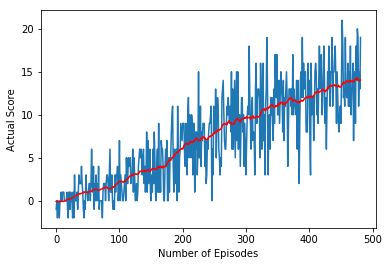

In [13]:
import matplotlib.pyplot as plt
np.random.seed(16)
from scipy.ndimage.filters import uniform_filter1d


n = len(scores)
# Draw the line plot
plt.plot(np.arange(n), scores)

# Draw the moving average
win_len = int(n/10)
mv_avg = uniform_filter1d(scores, size=win_len)
plt.plot(mv_avg,'-r');

# Define the label of the plots
plt.xlabel('Number of Episodes')
plt.ylabel('Actual Score')

     
# Display the plot
plt.show()

## Score the model and evaluate its performance

In [14]:
env_name = 'basic_banana'
dqn = dq_nav(name=env_name, state_size=state_size, action_size=action_size, env=env, seed_in=12345)
env.train_mode = False
scores = dqn.play(n_episodes=100,n_actions=10000, load=True)

Reward in this episode: 1.0	|	Accumulated reward of  21.0  in  99  episodess

In [ ]:
env.close()